In [78]:
import pandas as pd
import numpy as np
# need to register converters to handle plotting dates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import pycountry
from datetime import timedelta
import calendar

In [79]:
r_downloads_year_raw = pd.read_csv(
    'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2018/2018-10-30/r_downloads_year.csv',
    parse_dates=[['date', 'time'], 'date'], # creates date_time column at first index
    keep_date_col=True
)

### Data cleaning

In [80]:
def country_name(country_code: str) -> str:
    '''
    Returns country name from country code. If no matching country returns country code
    '''
    try:
        return pycountry.countries.get(alpha_2 = country_code).name
    # attribute error as no matching country thus None type as no name attribute
    except AttributeError:
        return None
    
# dropping index column 
r_downloads_year = r_downloads_year_raw.drop(columns=r_downloads_year_raw.columns[1])
    
r_downloads_year['country_name'] = r_downloads_year.country.apply(country_name)

# default order by date old -> new
r_downloads_year = r_downloads_year.sort_values(by='date_time').reset_index(drop=True)

# adding date_time info to be used
r_downloads_year['weekday'] = r_downloads_year.date.dt.weekday_name
r_downloads_year['week'] = r_downloads_year.date.dt.week
r_downloads_year['year'] = r_downloads_year.date.dt.year
r_downloads_year['hour'] = r_downloads_year.date_time.dt.hour

### R downlaods over time

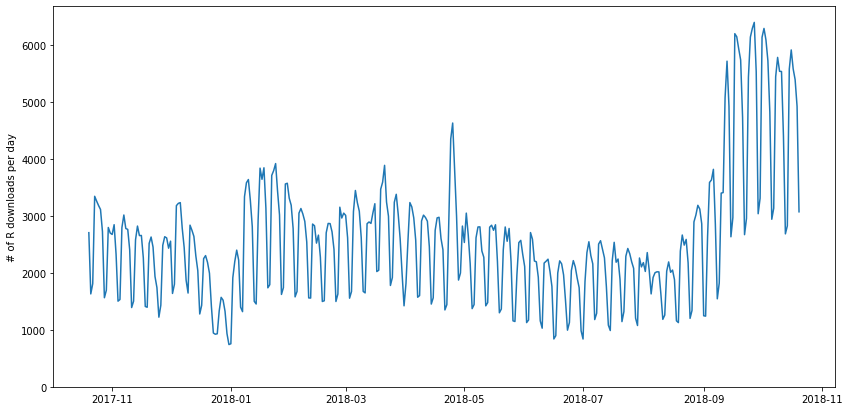

In [63]:
f, ax = plt.subplots(figsize=(14,7))

# downloads per day
data = r_downloads_year['date'].value_counts()\
                               .reset_index(name='downloads')\

sns.lineplot(x = 'index', # index is date as we used it to index our value_counts
             y = 'downloads',
             data = data,
             ax = ax,
             sort=True)

ax.set_ylim(0,)
ax.set_ylabel('# of R downloads per day')

ax.set_xlabel(None)

plt.show()

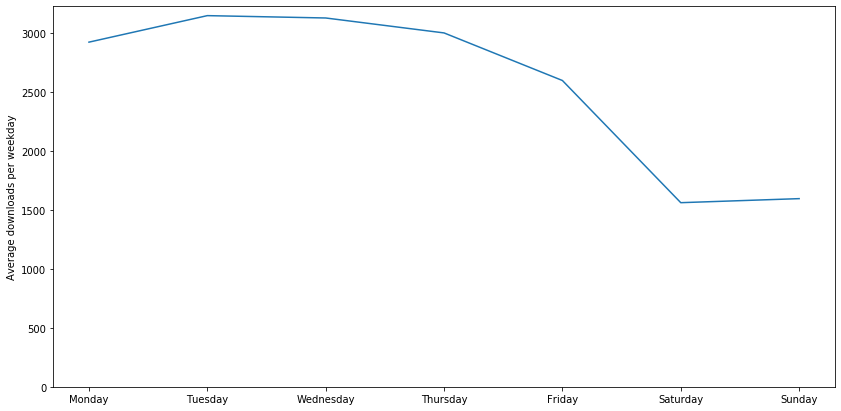

In [64]:
f, ax = plt.subplots(figsize=(14,7))

# downloads by weekday by date
data = r_downloads_year.groupby('weekday')['date'].value_counts()\
                                                  .reset_index(name='downloads')

# converting downloads to mean downloads per weekday
data = data.groupby('weekday', as_index=False)['downloads'].mean()

# specifying categorical order (mon -> sun)
data['weekday'] = pd.Categorical(data['weekday'], list(calendar.day_name))

sns.lineplot(x = 'weekday',
             y = 'downloads',
             data = data,
             ax = ax)

ax.set_xlabel(None)

ax.set_ylabel('Average downloads per weekday')
ax.set_ylim(0,)

plt.show()

R is downloaded about 1500 times each weekend day and around 3000 times on a typical weekday (averaged over the last year).

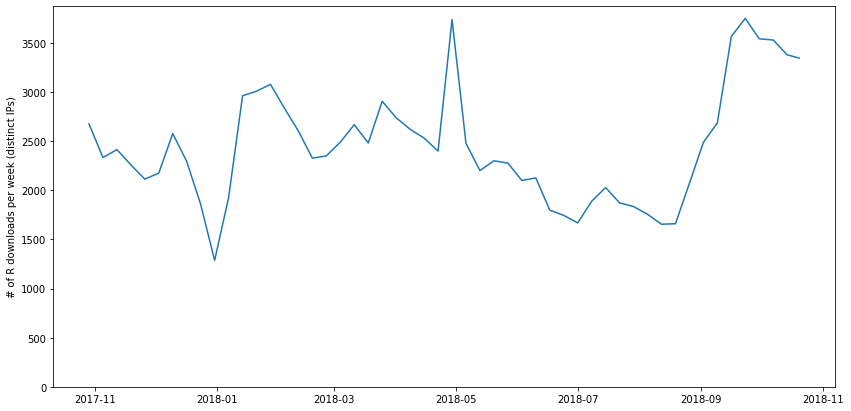

In [65]:
f, ax = plt.subplots(figsize=(14,7))

# unique ip downloads with weekend as date
# have to groupby year and week as week 42 is in both years
data = r_downloads_year.groupby(['year', 'week'], as_index=False).agg({'date': 'last',
                                                                       'ip_id': 'nunique'})\
                                                                                    .iloc[1:] # remove first week

sns.lineplot(x = 'date',
             y = 'ip_id',
             data = data,
             ax = ax,
             sort=False)

ax.set_xlabel(None)

ax.set_ylabel("# of R downloads per week (distinct IPs)")
ax.set_ylim(0,)

plt.show()

What time of day were people installing R?

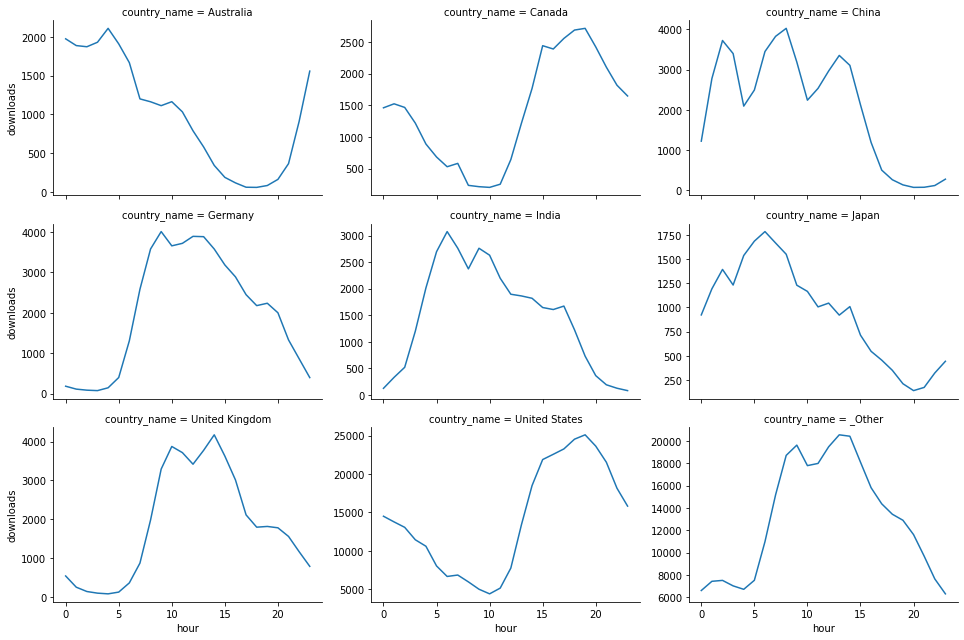

In [77]:
data = r_downloads_year.loc[r_downloads_year.country_name.notnull(), ['hour', 'country_name']]

# lumping everything outside top 8 countries into '_Other'
top_countries = data.country_name.value_counts().index[:8]
data.loc[~data.country_name.isin(top_countries), 'country_name'] = '_Other' # _ to ensure it is plotted last

# count country hourly downloads
data = data.groupby(['country_name', 'hour'])['hour'].count()\
                                                     .reset_index(name='downloads')

g = sns.FacetGrid(data, col="country_name", col_wrap=3, sharey=False, height=3, aspect=1.5)
g = g.map(plt.plot, "hour", "downloads")
    
plt.show()

### R downloads by country

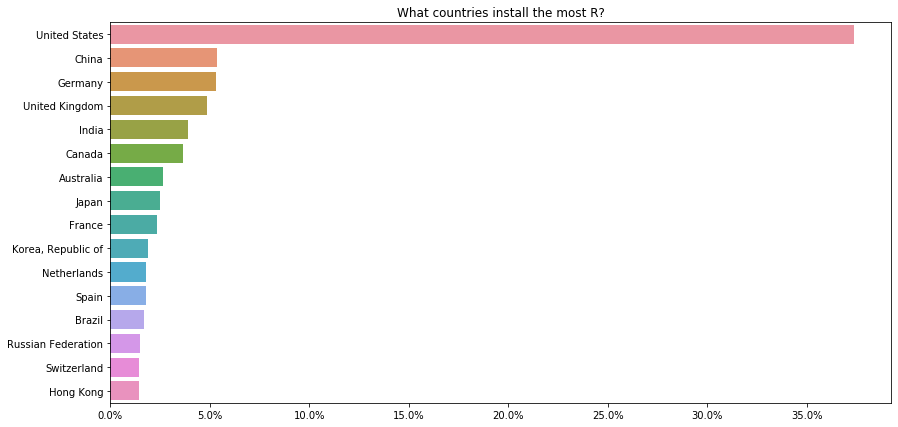

In [83]:
f, ax = plt.subplots(figsize=(14,7))

data = r_downloads_year.country_name.value_counts(normalize=True, sort=True, ascending=False)\
                                                                                        .head(16)\
                                                                                        .reset_index(name='percent')

sns.barplot(y = 'index',
            x = 'percent',
            data = data,
            orient='h',
            ax = ax)

ax.set_ylabel(None)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.))
ax.set_xlabel(None)

ax.set_title('What countries install the most R?')

plt.show()

More than a third of R installations come from the US.

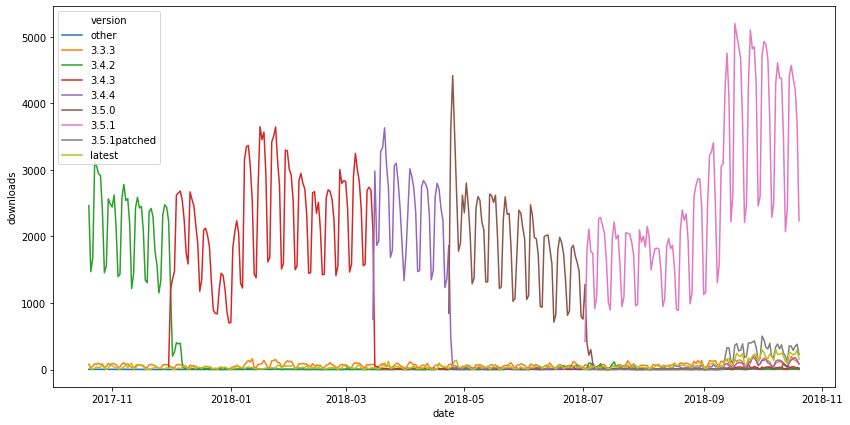

In [85]:
f, ax = plt.subplots(figsize=(14,7))

# count version daily downloads
data = r_downloads_year.groupby(['version', 'date'])['version'].count()\
                                                               .reset_index(name='downloads')

# lumping everything outside top 8 versions into 'other'
top_versions = r_downloads_year.version.value_counts().index[:8]
data.loc[~data.version.isin(top_versions), 'version'] = 'other'
    
sns.lineplot(x = 'date', 
             y = 'downloads', 
             hue = 'version', 
             data = data,
             ax = ax)
    
plt.show()

### Downloads by country

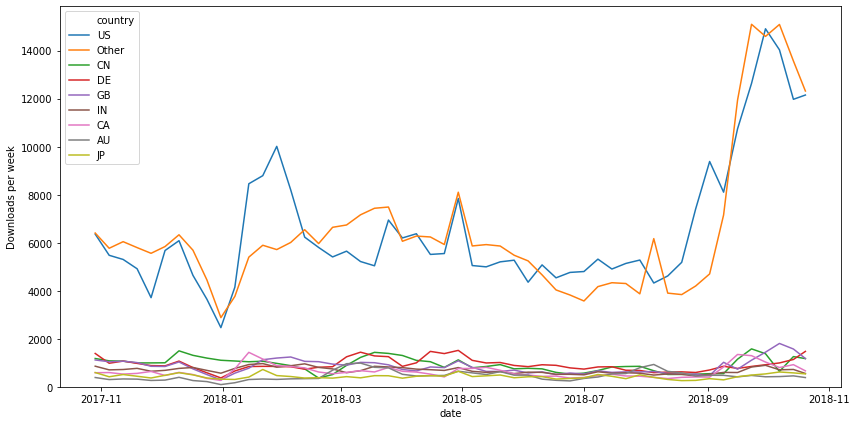

In [110]:
f, ax = plt.subplots(figsize=(14,7))

data = r_downloads_year[['year', 'week', 'date', 'country']].copy()

top_countries = data.country.value_counts().index[:8]
data.loc[~data.country.isin(top_countries), 'country'] = 'Other'

# downloads by weekday by year
data = data.groupby(['year', 'week', 'country'])['date'].value_counts()\
                                                        .reset_index(name='downloads')\
                                                        .sort_values(by='date')

# downloads now total weekly downloads by country
data = data.groupby(['year', 'week', 'country'], as_index=False).agg({'date': 'last',
                                                                      'downloads': 'sum'})

# removing first week
data = data[(data.year > 2017) | (data.week > 42)]

legend_order = data.groupby('country')['downloads'].sum().sort_values(ascending=False).index

sns.lineplot(x = 'date',
             y = 'downloads',
             hue ='country',
             hue_order = legend_order,
             data = data,
             ax = ax,
             sort=False)

ax.set_ylabel('Downloads per week')
ax.set_ylim(0,)

plt.show()

### R package downloads

In [111]:
package_downloads = pd.read_csv(
    'http://cran-logs.rstudio.com/2018/2018-10-27.csv.gz'
)

In [117]:
interesting_countries = ['US', 'IN']
data = package_downloads[package_downloads.country.isin(interesting_countries)]

# unique ip package downloads by country 
data = data.groupby(['country', 'package'], as_index=False).agg({'ip_id': 'nunique'})

# transform country downloads to columns
data = data.set_index(['package', 'country']).unstack(fill_value=0)['ip_id'].reset_index()
# because we set two index's when we reset country became column names so we're removing it
data.columns.name = None

data['total'] = data['IN'] + data['US']
data['IN'] = (data['IN'] + 1) / (sum(data['IN']) + 1)
data['US'] = (data['US'] + 1) / (sum(data['US']) + 1)
data['ratio'] = data['US'] / data['IN']

data = data[data.total >= 100]
data = data.sort_values(by='ratio', ascending=False)

In [118]:
data.head(10)

,package,IN,US,total,ratio
427,COUNT,0.000021,0.000888,223,41.363667
5201,msme,0.000021,0.000888,223,41.363667
6556,sunburstR,0.000043,0.001177,297,27.421895
5972,replyr,0.000021,0.000511,128,23.821040
3340,d3r,0.000064,0.001153,292,17.911945
2590,aws.signature,0.000043,0.000495,125,11.541202
4046,forge,0.000343,0.003634,931,10.583282
5815,r2d3,0.000343,0.003630,930,10.571741
6423,sparklyr,0.000429,0.003884,998,9.048302
6938,wrapr,0.000064,0.000547,139,8.494324


### Appendix: Why count only distinct IP's

In [123]:
r_downloads_gaps = r_downloads_year[['date_time','ip_id']].copy()
# gap between each download by ip_id in seconds 
r_downloads_gaps['gap'] = r_downloads_gaps.groupby('ip_id')['date_time'].diff() / np.timedelta64(1, 's') #converting to seconds

In [124]:
ip_counts = r_downloads_year.ip_id.value_counts()

In [125]:
print(f'A majority {( len(ip_counts[ip_counts>=100]) / len(ip_counts) )*100:.2f}% of IP addresses that installed R did so more than 100 time in a year')

A majority 63.05% of IP addresses that installed R did so more than 100 time in a year


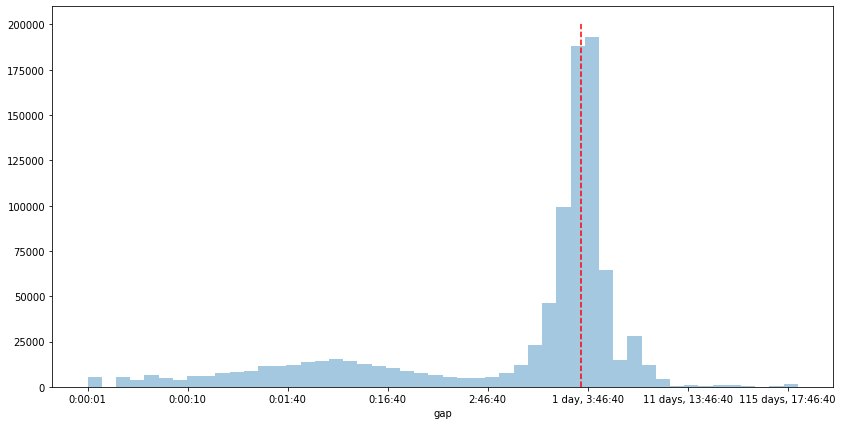

In [128]:
f, ax = plt.subplots(figsize=(14,7))

data = r_downloads_gaps[r_downloads_gaps.gap.notnull()]

sns.distplot(np.log10(data['gap'] + 1),
             kde=False,
             ax = ax)

# have to draw before getting labels
f.canvas.draw()

labels = [label.get_text() for label in ax.get_xticklabels()]

new_lables = [timedelta(seconds=int(s)) for s in 10**np.arange(0, len(labels))]
# setting first label to '' as 1st index is -1
ax.set_xticklabels([''] + new_lables)

# adding vertical line to indicate 1 day
day_log_value = np.log10(60*60*24)
plt.plot([day_log_value, day_log_value], [0, 200000], linestyle='--', color='red')

plt.show()